# Great Energy Predictor - Preprocessing
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

### Dependencies

In [1]:
import src.utils as udf

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# import os

# Pandas on dask
# os.environ['MODIN_ENGINE'] = 'dask'
# import modin.pandas as dd 

# Pandas on ray
# os.environ['MODIN_ENGINE'] = 'ray'
# import ray
# ray.init()
# import modin.pandas as ray

In [2]:
# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 12})

### Load data

In [3]:
path = '../data/from_eda/'
path_bldg = '../data/raw/'

In [4]:
meter = pd.read_csv(f'{path}meter.csv', parse_dates=['timestamp'])
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20138871 entries, 0 to 20138870
Data columns (total 11 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
site_id          int64
meter_type       object
dayofyear        int64
month            int64
day              int64
dayofweek        int64
hour             int64
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 1.7+ GB


In [5]:
meter = udf.reduce_mem_usage(meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20138871 entries, 0 to 20138870
Data columns (total 11 columns):
building_id      uint16
meter            uint8
timestamp        datetime64[ns]
meter_reading    float32
site_id          uint8
meter_type       object
dayofyear        uint16
month            uint8
day              uint8
dayofweek        uint8
hour             uint8
dtypes: datetime64[ns](1), float32(1), object(1), uint16(2), uint8(6)
memory usage: 576.2+ MB


In [6]:
weather = pd.read_csv(f'{path}weather.csv', parse_dates=['timestamp'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 10 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
hour                  139773 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 10.7 MB


In [7]:
weather = udf.reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 10 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float32
cloud_coverage        70600 non-null float32
dew_temperature       139660 non-null float32
precip_depth_1_hr     89484 non-null float32
sea_level_pressure    129155 non-null float32
wind_direction        133505 non-null float32
wind_speed            139469 non-null float32
hour                  139773 non-null uint8
dtypes: datetime64[ns](1), float32(7), uint8(2)
memory usage: 5.1 MB


In [8]:
building = pd.read_csv(f'{path_bldg}building_metadata.csv')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [9]:
building = udf.reduce_mem_usage(building)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null uint8
building_id    1449 non-null uint16
primary_use    1449 non-null object
square_feet    1449 non-null uint32
year_built     675 non-null float32
floor_count    355 non-null float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 32.7+ KB


In [10]:
del path, path_bldg
gc.collect()

44

### Preprocessing - Meter

In [11]:
meter.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour
0,0,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
1,1,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
2,2,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
3,3,0,2016-01-01,0.0,0,electricity,1,1,1,4,0
4,4,0,2016-01-01,0.0,0,electricity,1,1,1,4,0


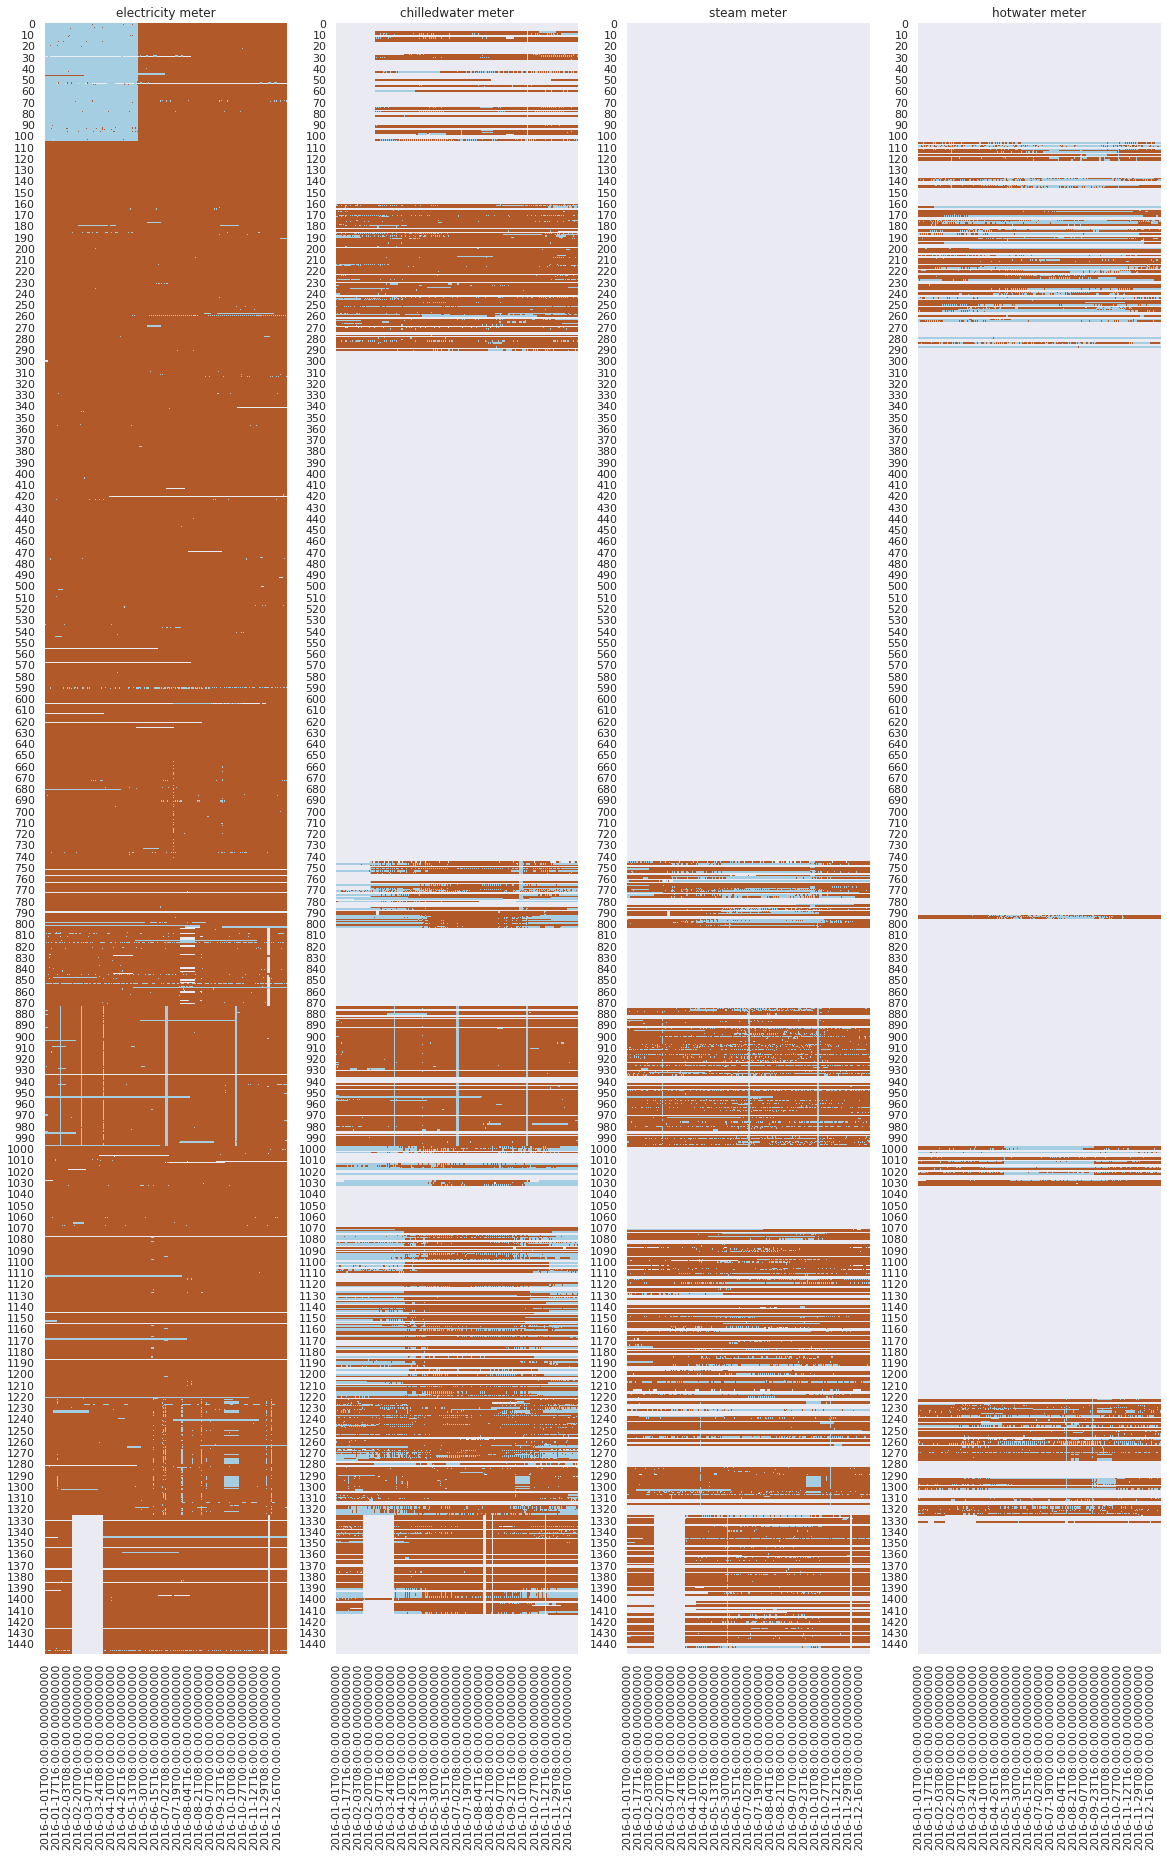

In [12]:
# Visualize missing values and zeroes
# Adapted from: https://www.kaggle.com/hmendonca/clean-weather-data-eda#Check-the-meter-averages-per-weekday

types = ['electricity', 'chilledwater', 'steam', 'hotwater']
fig, ax = plt.subplots(1, 4, figsize=(20,30))

for m in range(4):
    
    df = meter[meter.meter == m]
    mmap = df.pivot(index='building_id', columns='timestamp', values='meter_reading')
    mmap = mmap.reindex(sorted(meter.building_id.unique()))
    mmap = np.sign(mmap)
    
    sns.heatmap(mmap, cmap='Paired', ax=ax[m], cbar=False)
    ax[m].set_title(f'{types[m]} meter')
    ax[m].set_ylabel(None)
    ax[m].set_xlabel(None)

In [13]:
# Drop observations with a meter reading of 0
meter.drop(index=meter[meter.meter_reading <= 0].index, inplace=True)
meter.shape

(18264895, 11)

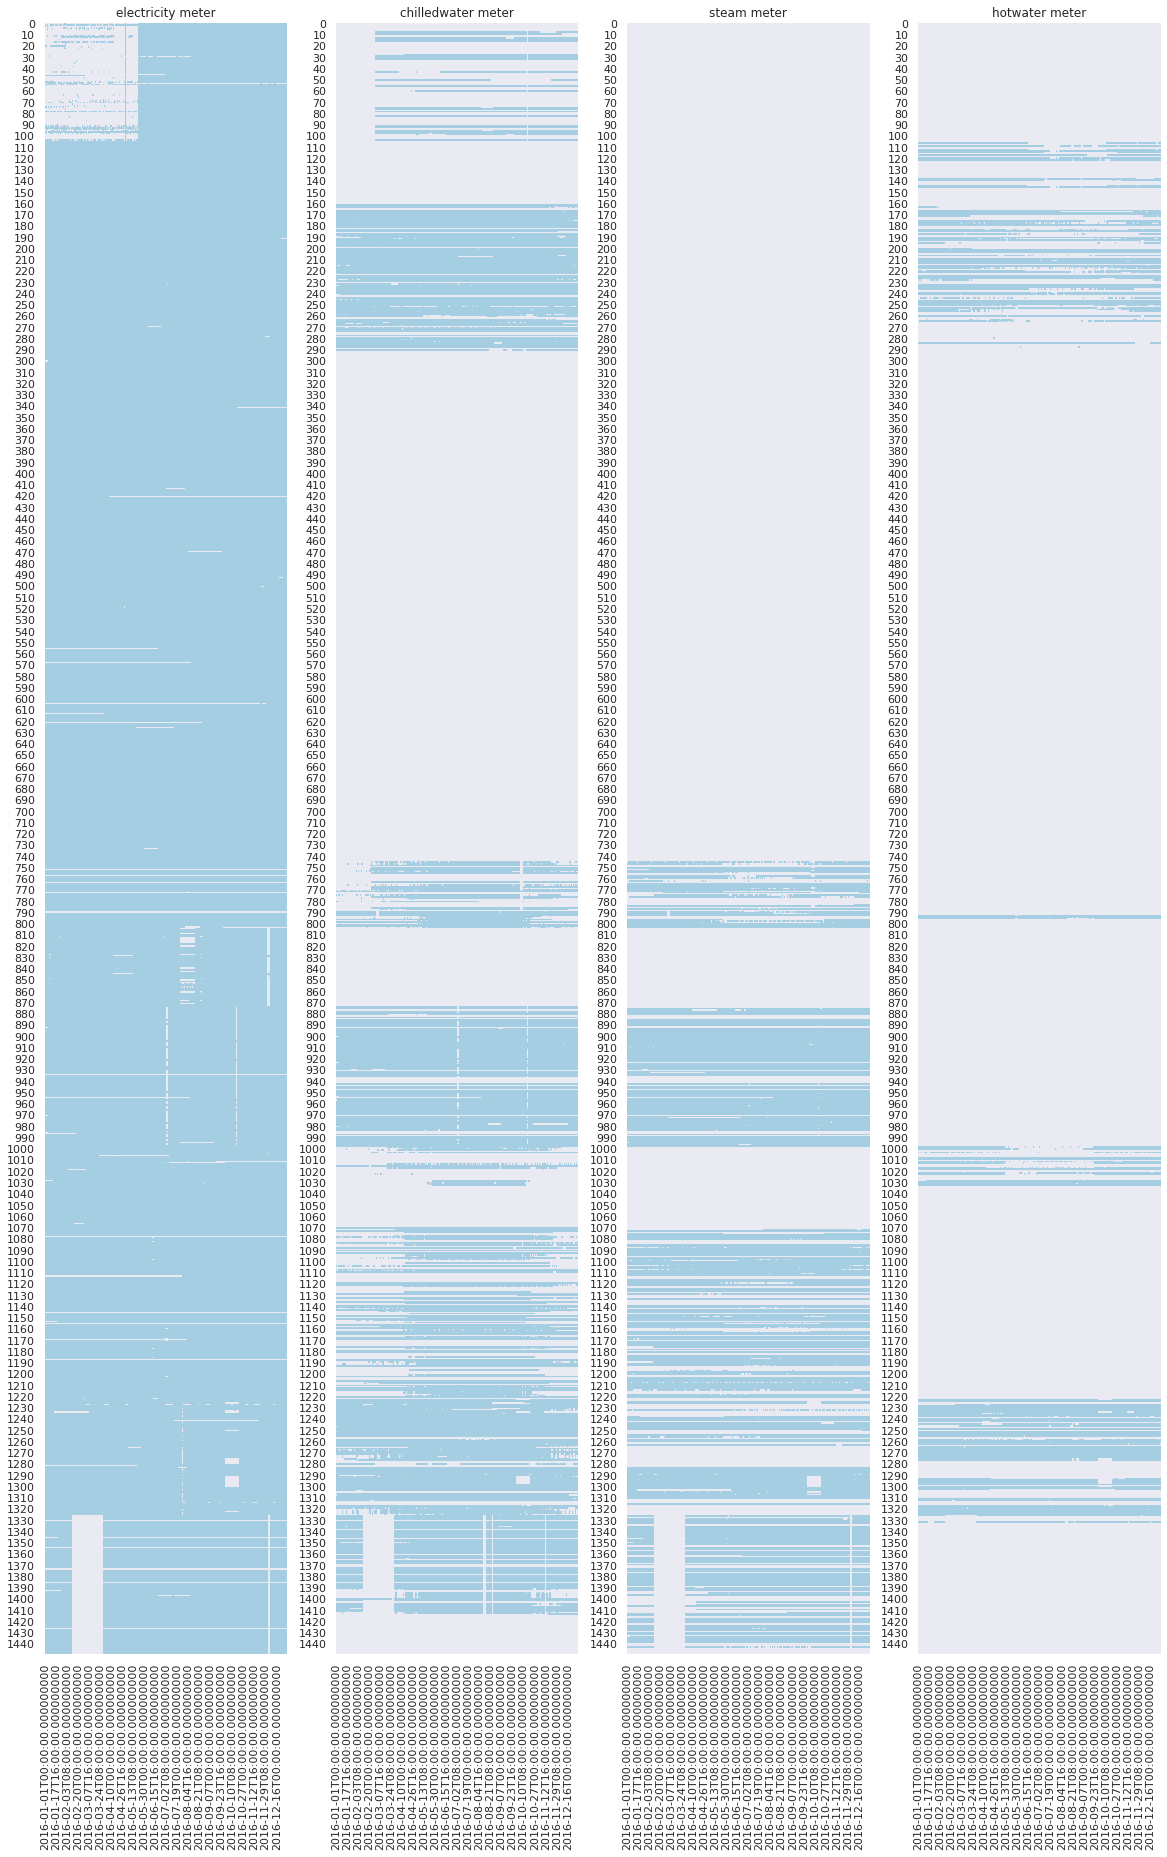

In [14]:
# Check zeroes again
fig, ax = plt.subplots(1, 4, figsize=(20,30))
for m in range(4):
    df = meter[meter.meter == m]
    mmap = df.pivot(index='building_id', columns='timestamp', values='meter_reading')
    mmap = mmap.reindex(sorted(meter.building_id.unique()))
    mmap = np.sign(mmap)
    sns.heatmap(mmap, cmap='Paired', ax=ax[m], cbar=False)
    ax[m].set_title(f'{types[m]} meter')
    ax[m].set_ylabel(None)
    ax[m].set_xlabel(None)

In [15]:
# # Inspect buildings with a year_built of 2016 and 2017
# yb1617 = building[(building.year_built == 2016) | (building.year_built == 2017)]
# yb1617

In [16]:
# # Count the number of meter readings in these buildings
# bldgs = yb1617.building_id.tolist()
# mr1617 = [meter[meter.building_id == bldg].shape[0] for bldg in bldgs]

# # Add the total
# bldgs.append('Total')
# mr1617.append(sum(mr1617))

# # Convert to dataframe
# pd.DataFrame(zip(bldgs, mr1617), columns=['building', 'meter_reading_count'])

In [17]:
# # Add year_built to meter dataframe
# meter = pd.merge(meter, building[['building_id', 'year_built']], on='building_id', how='left')
# meter.head()

In [18]:
# # Remove 2016 and 2017 buildings
# meter = meter[(meter.year_built != 2016) & (meter.year_built != 2017)]
# meter.shape

In [19]:
del types, fig, ax, m, df, mmap # , yb1617, bldgs, mr1617
gc.collect()

39214

### Preprocessing - Weather

In [20]:
weather.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
139768,15,2016-12-31 14:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7,14
139769,15,2016-12-31 15:00:00,2.8,2.0,-8.9,NaN,1007.400024,180.0,7.7,15
139770,15,2016-12-31 16:00:00,2.8,NaN,-7.2,NaN,1007.500000,180.0,5.1,16
139771,15,2016-12-31 17:00:00,2.2,NaN,-6.7,NaN,1008.000000,170.0,4.6,17
139772,15,2016-12-31 18:00:00,1.7,NaN,-5.6,-1.0,1008.500000,180.0,8.8,18


In [21]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 10 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float32
cloud_coverage        70600 non-null float32
dew_temperature       139660 non-null float32
precip_depth_1_hr     89484 non-null float32
sea_level_pressure    129155 non-null float32
wind_direction        133505 non-null float32
wind_speed            139469 non-null float32
hour                  139773 non-null uint8
dtypes: datetime64[ns](1), float32(7), uint8(2)
memory usage: 5.1 MB


In [22]:
# Reindex to include every hour of every day in 2016
weather = udf.reidx_site_time(weather, tstart='1/1/2016 00:00:00', tend='12/31/2016 23:00:00')

# Reset hour column
weather['hour'] = weather.timestamp.dt.hour
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 10 columns):
site_id               140544 non-null uint64
timestamp             140544 non-null datetime64[ns]
air_temperature       139651 non-null float32
cloud_coverage        70566 non-null float32
dew_temperature       139593 non-null float32
precip_depth_1_hr     89435 non-null float32
sea_level_pressure    129092 non-null float32
wind_direction        133441 non-null float32
wind_speed            139402 non-null float32
hour                  140544 non-null int64
dtypes: datetime64[ns](1), float32(7), int64(1), uint64(1)
memory usage: 7.0 MB


In [23]:
weather.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour
140539,15,2016-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
140540,15,2016-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
140541,15,2016-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
140542,15,2016-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
140543,15,2016-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23


In [24]:
# Missing values
wmissing = pd.DataFrame(zip(weather.isnull().sum(), np.round(weather.isnull().mean() * 100, 2)), 
                        index=weather.columns, 
                        columns=['missing', 'pct_missing'])
wmissing

,missing,pct_missing
site_id,0,0.00
timestamp,0,0.00
air_temperature,893,0.64
cloud_coverage,69978,49.79
dew_temperature,951,0.68
precip_depth_1_hr,51109,36.37
sea_level_pressure,11452,8.15
wind_direction,7103,5.05
wind_speed,1142,0.81
hour,0,0.00


In [25]:
# Missing values by site
udf.locate_missing(weather, pct=True)

,timestamp,pct_missing_air_temperature,pct_missing_cloud_coverage,pct_missing_dew_temperature,pct_missing_precip_depth_1_hr,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed,pct_missing_hour
site_id,,,,,,,,,
0,8784,0.09,43.65,0.09,0.06,1.02,2.90,0.06,0.0
1,8784,0.25,80.64,0.25,100.00,0.83,0.27,0.24,0.0
2,8784,0.10,26.88,0.10,0.83,0.59,6.82,0.15,0.0
3,8784,0.15,41.53,0.17,0.51,1.90,1.84,0.15,0.0
4,8784,0.09,48.25,0.11,15.08,0.92,1.28,0.09,0.0
5,8784,0.35,68.98,0.35,100.00,100.00,3.69,0.36,0.0
6,8784,0.18,34.11,0.18,0.07,2.05,8.94,0.51,0.0
7,8784,1.99,100.00,2.25,91.68,2.08,1.99,1.99,0.0
8,8784,0.09,43.65,0.09,0.06,1.02,2.90,0.06,0.0


In [26]:
# Drop cloud_coverage and precip_depth_1_hr
weather.drop(['cloud_coverage', 'precip_depth_1_hr'], axis=1, inplace=True)
weather.head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
0,0,2016-01-01 00:00:00,19.4,19.4,NaN,0.0,0.0,0
1,0,2016-01-01 01:00:00,21.1,21.1,1019.400024,0.0,0.0,1
2,0,2016-01-01 02:00:00,21.1,21.1,1018.799988,210.0,1.5,2
3,0,2016-01-01 03:00:00,20.6,20.0,1018.099976,0.0,0.0,3
4,0,2016-01-01 04:00:00,21.1,20.6,1019.000000,290.0,1.5,4


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8aedb47130>,
      dtype=object)

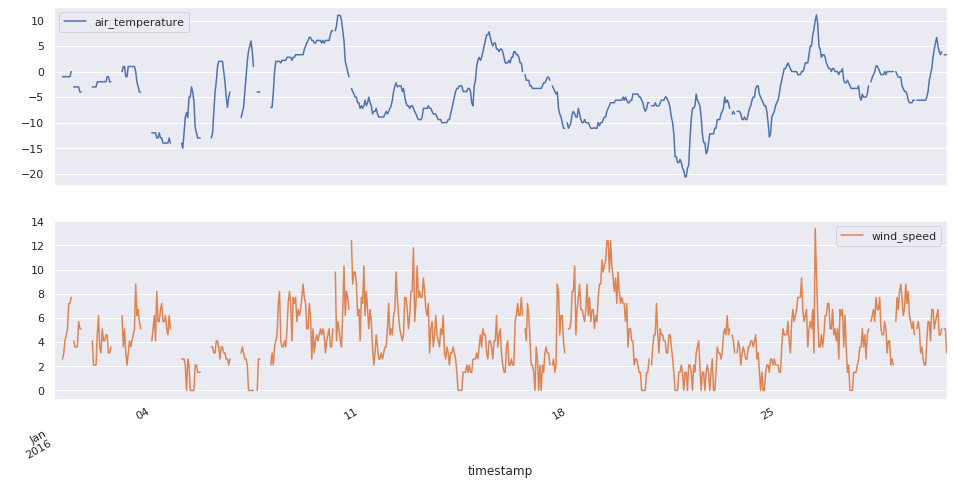

In [27]:
# Time interval to plot
start, end = datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)

# Plot site 15 air temperature and wind speed
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, figsize=(16, 8))

In [28]:
# Use linear interpolation for variables with min/max constraints and cubic interpolation for the rest
lin_cols = ['wind_direction', 'wind_speed']
cub_cols = ['air_temperature', 'dew_temperature', 'sea_level_pressure']

# Fill missing values by site
weather = udf.fill_missing(weather, [], lin_cols, cub_cols)
udf.locate_missing(weather, pct=True)

,timestamp,pct_missing_air_temperature,pct_missing_dew_temperature,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed,pct_missing_hour
site_id,,,,,,,
0,8784,0.0,0.0,0.0,0.0,0.0,0.0
1,8784,0.0,0.0,0.0,0.0,0.0,0.0
2,8784,0.0,0.0,0.0,0.0,0.0,0.0
3,8784,0.0,0.0,0.0,0.0,0.0,0.0
4,8784,0.0,0.0,0.0,0.0,0.0,0.0
5,8784,0.0,0.0,100.0,0.0,0.0,0.0
6,8784,0.0,0.0,0.0,0.0,0.0,0.0
7,8784,0.0,0.0,0.0,0.0,0.0,0.0
8,8784,0.0,0.0,0.0,0.0,0.0,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8aed991250>,
      dtype=object)

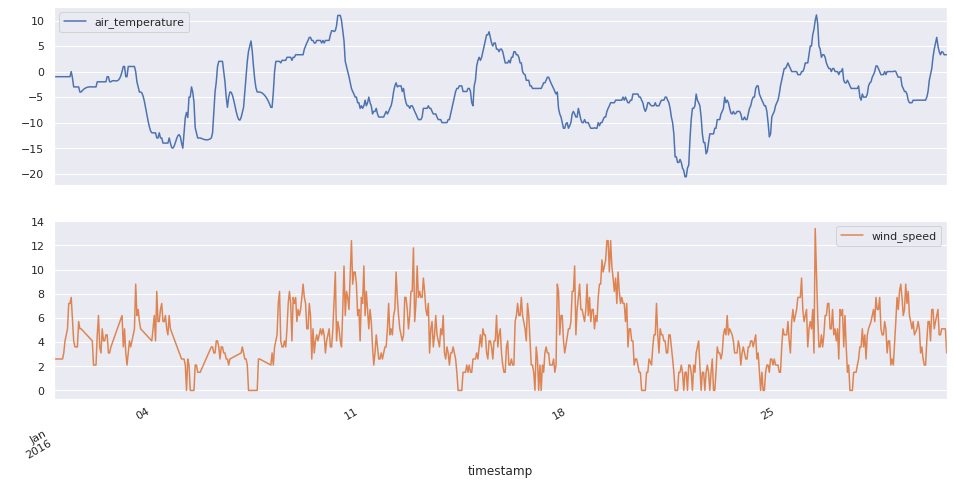

In [29]:
# Plot site 15 air temperature and wind speed
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, figsize=(16, 8))

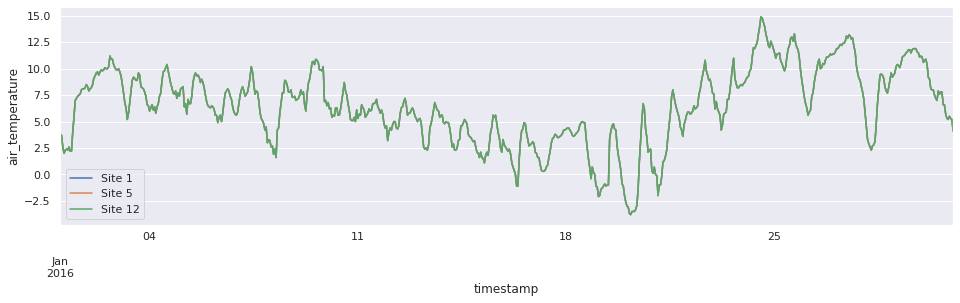

In [30]:
# Extract the 3 European sites
w1 = udf.get_site(weather, 1, time_idx=True)
w5 = udf.get_site(weather, 1, time_idx=True)
w12 = udf.get_site(weather, 1, time_idx=True)

# Air temperature in January from all 3
w1.loc[start:end, 'air_temperature'].plot()
w5.loc[start:end, 'air_temperature'].plot()
w12.loc[start:end, 'air_temperature'].plot()
plt.ylabel('air_temperature')
plt.legend(['Site 1', 'Site 5', 'Site 12']);

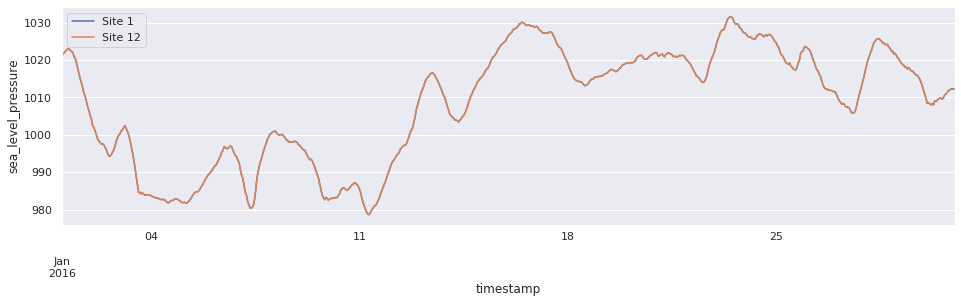

In [31]:
# Sea-level pressure in January from sites 
w1.loc[start:end, 'sea_level_pressure'].plot()
w12.loc[start:end, 'sea_level_pressure'].plot()
plt.ylabel('sea_level_pressure')
plt.legend(['Site 1', 'Site 12']);

In [32]:
# Site 1 weather
weather[weather.site_id == 1].head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
8784,1,2016-01-01 00:00:00,3.8,2.4,1020.900024,240.0,3.1,0
8785,1,2016-01-01 01:00:00,3.7,2.4,1021.599976,230.0,2.6,1
8786,1,2016-01-01 02:00:00,2.6,1.9,1021.900024,0.0,0.0,2
8787,1,2016-01-01 03:00:00,2.0,1.2,1022.299988,170.0,1.5,3
8788,1,2016-01-01 04:00:00,2.3,1.8,1022.700012,110.0,1.5,4


In [33]:
# Indices of sites 1 and 5
i1 = weather[weather.site_id == 1].index 
i5 = weather[weather.site_id == 5].index

# Copy site 1's sea_level_pressure data over to site 5
weather.loc[i5, 'sea_level_pressure'] = weather.loc[i1, 'sea_level_pressure'].values
weather[weather.site_id == 5].head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
43920,5,2016-01-01 00:00:00,5.0,2.0,1020.900024,260.0,2.6,0
43921,5,2016-01-01 01:00:00,5.0,2.0,1021.599976,260.0,2.6,1
43922,5,2016-01-01 02:00:00,3.0,1.0,1021.900024,210.0,1.5,2
43923,5,2016-01-01 03:00:00,4.0,3.0,1022.299988,160.0,2.6,3
43924,5,2016-01-01 04:00:00,4.0,3.0,1022.700012,110.0,4.1,4


In [34]:
# Missing values
weather.isnull().sum()

site_id               0
timestamp             0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
dtype: int64

In [35]:
# Recast wind_direction to integer type
weather['wind_direction'] = weather.wind_direction.astype('int')

# Reduce memory usage
weather = udf.reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 8 columns):
site_id               140544 non-null uint8
timestamp             140544 non-null datetime64[ns]
air_temperature       140544 non-null float32
dew_temperature       140544 non-null float32
sea_level_pressure    140544 non-null float32
wind_direction        140544 non-null uint16
wind_speed            140544 non-null float32
hour                  140544 non-null uint8
dtypes: datetime64[ns](1), float32(4), uint16(1), uint8(2)
memory usage: 3.8 MB


In [36]:
del wmissing, start, end, w15, lin_cols, cub_cols, w1, w5, w12, i1, i5
gc.collect()

8145

### Preprocessing - Building

In [37]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [38]:
# Missing values
bmissing = pd.DataFrame(zip(building.isnull().sum(), round(building.isnull().mean() * 100, 2)), 
                        index=building.columns, 
                        columns=['missing', 'pct_missing'])
bmissing

,missing,pct_missing
site_id,0,0.00
building_id,0,0.00
primary_use,0,0.00
square_feet,0,0.00
year_built,774,53.42
floor_count,1094,75.50


In [39]:
# Feature correlation
building.corr()

,site_id,building_id,square_feet,year_built,floor_count
site_id,1.000000,0.977283,0.082136,-0.187021,-0.468542
building_id,0.977283,1.000000,0.074312,-0.230185,-0.482477
square_feet,0.082136,0.074312,1.000000,0.109063,0.530298
year_built,-0.187021,-0.230185,0.109063,1.000000,0.099393
floor_count,-0.468542,-0.482477,0.530298,0.099393,1.000000


In [40]:
# Drop floor_count
building.drop('floor_count', axis=1, inplace=True)

# Add missing indicator for year_built
building['missing_year'] = building.year_built.isnull().astype(int)

building.head()

,site_id,building_id,primary_use,square_feet,year_built,missing_year
0,0,0,Education,7432,2008.0,0
1,0,1,Education,2720,2004.0,0
2,0,2,Education,5376,1991.0,0
3,0,3,Education,23685,2002.0,0
4,0,4,Education,116607,1975.0,0


In [41]:
# Number of buildings missing year by site
num_vals = building.groupby('site_id').building_id.count()
num_miss = building.groupby('site_id').missing_year.sum()
year_missing = pd.DataFrame(zip(num_vals, num_miss), columns=['num_values', 'num_missing'])
year_missing['pct_missing'] = np.round(year_missing.num_missing * 100 / year_missing.num_values, 2)
year_missing

,num_values,num_missing,pct_missing
0,105,0,0.00
1,51,11,21.57
2,135,41,30.37
3,274,142,51.82
4,91,2,2.20
5,89,1,1.12
6,44,44,100.00
7,15,1,6.67
8,70,70,100.00
9,124,124,100.00


/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


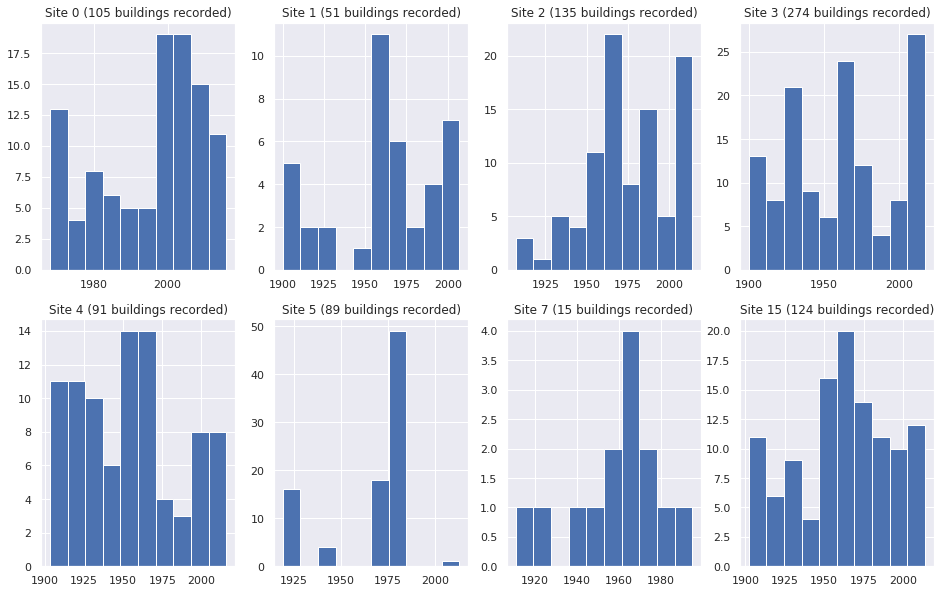

In [42]:
# Sites with at least 1 recorded year_built
sites = year_missing[year_missing.pct_missing < 100].index
s = 0

# Plot these sites
fig, ax = plt.subplots(2, 4, figsize=(16, 10))
for a in ax:
    for b in range(4):
        bldg = building[building.site_id == sites[s]]
        a[b].hist(bldg.year_built)
        a[b].set_title('Site %d (%d buildings recorded)' % (sites[s], bldg.shape[0]))
        s += 1

In [43]:
# Fill missing year_built with the building's site median
building.year_built = building.groupby('site_id').year_built.transform(lambda y: y.fillna(y.median()))
(num_vals - building.groupby('site_id').year_built.count()) * 100 / num_vals

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


site_id
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6     100.0
7       0.0
8     100.0
9     100.0
10    100.0
11    100.0
12    100.0
13    100.0
14    100.0
15      0.0
dtype: float64

In [44]:
# Fill the other sites with primary_use medians
building.year_built = building.groupby('primary_use').year_built.transform(lambda y: y.fillna(y.median()))

# Fill the rest with the building's site median
building.year_built = building.groupby('site_id').year_built.transform(lambda y: y.fillna(y.median())).astype(int)

building.isnull().sum()

site_id         0
building_id     0
primary_use     0
square_feet     0
year_built      0
missing_year    0
dtype: int64

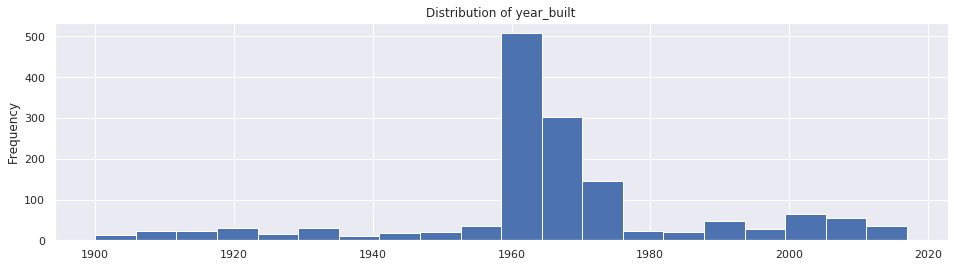

In [45]:
building.year_built.plot.hist(bins=20, title='Distribution of year_built')

In [46]:
del bmissing, num_vals, num_miss, year_missing, sites, s, fig, ax, a, b, bldg
gc.collect()

21937

### Merge dataframes

In [47]:
meter.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour
45,46,0,2016-01-01,15.604556,0,electricity,1,1,1,4,0
72,74,0,2016-01-01,12.603682,0,electricity,1,1,1,4,0
91,93,0,2016-01-01,15.364478,0,electricity,1,1,1,4,0
103,105,0,2016-01-01,23.303600,1,electricity,1,1,1,4,0
104,106,0,2016-01-01,0.374600,1,electricity,1,1,1,4,0


In [48]:
# Merge meter and building dataframes
# meter.drop('year_built', axis=1, inplace=True)
mb = pd.merge(meter, building.drop('site_id', axis=1), on='building_id', how='left')
mb.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour,primary_use,square_feet,year_built,missing_year
0,46,0,2016-01-01,15.604556,0,electricity,1,1,1,4,0,Retail,9045,2016,0
1,74,0,2016-01-01,12.603682,0,electricity,1,1,1,4,0,Parking,387638,1997,0
2,93,0,2016-01-01,15.364478,0,electricity,1,1,1,4,0,Office,33370,1982,0
3,105,0,2016-01-01,23.303600,1,electricity,1,1,1,4,0,Education,50623,1960,1
4,106,0,2016-01-01,0.374600,1,electricity,1,1,1,4,0,Education,5374,1960,1


In [49]:
weather.head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
0,0,2016-01-01 00:00:00,19.4,19.4,1019.400024,0,0.0,0
1,0,2016-01-01 01:00:00,21.1,21.1,1019.400024,0,0.0,1
2,0,2016-01-01 02:00:00,21.1,21.1,1018.799988,210,1.5,2
3,0,2016-01-01 03:00:00,20.6,20.0,1018.099976,0,0.0,3
4,0,2016-01-01 04:00:00,21.1,20.6,1019.000000,290,1.5,4


In [50]:
# Add weather to the merge
train = pd.merge(mb, weather.drop('hour', axis=1), on=['site_id', 'timestamp'], how='left')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour,primary_use,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,46,0,2016-01-01,15.604556,0,electricity,1,1,1,4,0,Retail,9045,2016,0,19.4,19.4,1019.400024,0,0.0
1,74,0,2016-01-01,12.603682,0,electricity,1,1,1,4,0,Parking,387638,1997,0,19.4,19.4,1019.400024,0,0.0
2,93,0,2016-01-01,15.364478,0,electricity,1,1,1,4,0,Office,33370,1982,0,19.4,19.4,1019.400024,0,0.0
3,105,0,2016-01-01,23.303600,1,electricity,1,1,1,4,0,Education,50623,1960,1,3.8,2.4,1020.900024,240,3.1
4,106,0,2016-01-01,0.374600,1,electricity,1,1,1,4,0,Education,5374,1960,1,3.8,2.4,1020.900024,240,3.1


In [51]:
# Reorder columns
cols = ['site_id', 'building_id', 'meter', 'meter_type', 'timestamp', 'meter_reading', 
        'air_temperature', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed', 
        'primary_use', 'square_feet', 'year_built', 'missing_year', 
        'dayofyear', 'month', 'day', 'hour', 'dayofweek']
train = train[cols]
train.head()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,month,day,hour,dayofweek
0,0,46,0,electricity,2016-01-01,15.604556,19.4,19.4,1019.400024,0,0.0,Retail,9045,2016,0,1,1,1,0,4
1,0,74,0,electricity,2016-01-01,12.603682,19.4,19.4,1019.400024,0,0.0,Parking,387638,1997,0,1,1,1,0,4
2,0,93,0,electricity,2016-01-01,15.364478,19.4,19.4,1019.400024,0,0.0,Office,33370,1982,0,1,1,1,0,4
3,1,105,0,electricity,2016-01-01,23.303600,3.8,2.4,1020.900024,240,3.1,Education,50623,1960,1,1,1,1,0,4
4,1,106,0,electricity,2016-01-01,0.374600,3.8,2.4,1020.900024,240,3.1,Education,5374,1960,1,1,1,1,0,4


In [52]:
del cols
gc.collect()

66

### Save dataframes

In [53]:
# path = '../data/from_pre/'
path = 'gb_model/datasets/'

In [54]:
building.to_pickle(f'{path}building.pkl')
pd.read_pickle(f'{path}building.pkl')

,site_id,building_id,primary_use,square_feet,year_built,missing_year
0,0,0,Education,7432,2008,0
1,0,1,Education,2720,2004,0
2,0,2,Education,5376,1991,0
3,0,3,Education,23685,2002,0
4,0,4,Education,116607,1975,0
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914,0
1445,15,1445,Education,4298,1964,1
1446,15,1446,Entertainment/public assembly,11265,1997,0
1447,15,1447,Lodging/residential,29775,2001,0


In [112]:
weather.to_csv(f'{path}weather.csv', index=False)
weather = pd.read_csv(f'{path}weather.csv', parse_dates=['timestamp'])
weather.head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
0,0,2016-01-01 00:00:00,19.4,19.4,1019.4,0,0.0,0
1,0,2016-01-01 01:00:00,21.1,21.1,1019.4,0,0.0,1
2,0,2016-01-01 02:00:00,21.1,21.1,1018.8,210,1.5,2
3,0,2016-01-01 03:00:00,20.6,20.0,1018.1,0,0.0,3
4,0,2016-01-01 04:00:00,21.1,20.6,1019.0,290,1.5,4


In [113]:
mb.to_pickle(f'{path}metr_bldg.pkl')
mb = pd.read_pickle(f'{path}metr_bldg.pkl')
mb.head()

,building_id,meter,timestamp,meter_reading,site_id,meter_type,dayofyear,month,day,dayofweek,hour,primary_use,square_feet,year_built,missing_year
0,46,0,2016-01-01,15.604556,0,electricity,1,1,1,4,0,Retail,9045,2016,0
1,74,0,2016-01-01,12.603682,0,electricity,1,1,1,4,0,Parking,387638,1997,0
2,93,0,2016-01-01,15.364478,0,electricity,1,1,1,4,0,Office,33370,1982,0
3,105,0,2016-01-01,23.303600,1,electricity,1,1,1,4,0,Education,50623,1960,1
4,106,0,2016-01-01,0.374600,1,electricity,1,1,1,4,0,Education,5374,1960,1


In [114]:
train.to_pickle(f'{path}train.pkl')
train = pd.read_pickle(f'{path}train.pkl')
train.head()

,site_id,building_id,meter,meter_type,timestamp,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,month,day,hour,dayofweek
0,0,46,0,electricity,2016-01-01,15.604556,19.4,19.4,1019.400024,0,0.0,Retail,9045,2016,0,1,1,1,0,4
1,0,74,0,electricity,2016-01-01,12.603682,19.4,19.4,1019.400024,0,0.0,Parking,387638,1997,0,1,1,1,0,4
2,0,93,0,electricity,2016-01-01,15.364478,19.4,19.4,1019.400024,0,0.0,Office,33370,1982,0,1,1,1,0,4
3,1,105,0,electricity,2016-01-01,23.303600,3.8,2.4,1020.900024,240,3.1,Education,50623,1960,1,1,1,1,0,4
4,1,106,0,electricity,2016-01-01,0.374600,3.8,2.4,1020.900024,240,3.1,Education,5374,1960,1,1,1,1,0,4
